# Vehicle State Plotting

This example demonstrates how to

1. Spawn a vehicle at a certain point and orientation on a map.
2. Set its AI to automatically cover the drivable reachable roads on the map.
3. Continually retrieve information about the while it's driving. This information includes:
    1. Position
    2. Direction
    3. Wheel speed
    4. Throttle intensity
    5. Brake intensity

The information obtained will then be plotted in various ways (mostly for demonstration, the plots themselves might not be particularly insightful.)

## Setup

This code block will import necessary dependencies for this example. Most relevant are BeamNGpy's classes:

1. `BeamNGpy`: The library's backbone that launches and communicates with the BeamNG.research simulator.
2. `Vehicle`: This class is used for interactions with vehicles in the simulation. It provides methods to query the state of the vehicle, control its actuators & built-in AI, and options to attach sensors that expose data in a way similar to real-life vehicle sensors.
2. `Scenario`: A class that offers methods of scenario creation. It is used to specify which environment is to be loaded and what vehicles act in the scenario.

Additionally, some sensors get included from the `sensors` package which, as the name implies, contains sensors that can be attached to a vehicle. The only one used in this demo is the `Electrics` sensor, which can be used to retrive data from the vehicle's electrical systems, such as the currently measures throttle and brake intensity or the wheel speed.

In [1]:
%matplotlib inline

import time

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from beamngpy import BeamNGpy, Vehicle, Scenario
from beamngpy.sensors import Electrics

sns.set()  # Make seaborn set matplotlib styling

With dependencies imported, we can start setting up a basic scenario with one vehicle. This can easily be adapted to multiple vehicles, but for demonstration purposes we stick to one.

In [2]:
# Instantiate a BeamNGpy instance the other classes use for reference & communication
beamng = BeamNGpy('localhost', 64256)  # This is the host & port used to communicate over

# Create a vehile instance that will be called 'ego' in the simulation
# using the etk800 model the simulator ships with
vehicle = Vehicle('ego', model='etk800', licence='PYTHON', colour='Green')
# Create an Electrics sensor and attach it to the vehicle
electrics = Electrics()
vehicle.attach_sensor('electrics', electrics)

# Create a scenario called vehicle_state taking place in the west_coast_usa map the simulator ships with
scenario = Scenario('west_coast_usa', 'vehicle_state')
# Add the vehicle and specify that it should start at a certain position and orientation.
# The position & orientation values were obtained by opening the level in the simulator,
# hitting F11 to open the editor and look for a spot to spawn and simply noting down the
# corresponding values.
scenario.add_vehicle(vehicle, pos=(-717.121, 101, 118.675), rot=(0, 0, 45))  # 45 degree rotation around the z-axis

# The make function of a scneario is used to compile the scenario and produce a scenario file the simulator can load
scenario.make(beamng)

## Running

With scenario and vehicles set up, we can launch the simulator and make it load our created scenario. This will start up the simulator, load the map specified by our scenario, and spawn the vehicles we've added to them, including their sensors.

In [3]:
bng = beamng.open()
bng.load_scenario(scenario)
bng.start_scenario()  # After loading, the simulator waits for further input to actually start

After loading & starting the scenario, the vehicle is located at the position specified in the scenario and awaits further input. This could be done by the user in the simulator itself through keyboard or a controller, or by calling the `control()` function of the vehicle with steering, brake, and throttle values. Besides those, the `Vehicle` class also exposes AI functions the simulator ships with. One of these is telling the AI to "span" the map, making it drive on every road reachable from its current position. The following code block makes the vehicle do that: drive on every road it can find from its current position.

In order to actually collect data about the state of the vehicle, we also initialise some lists to store our collected data.

In [4]:
vehicle.ai_set_mode('span')

positions = list()
directions = list()
wheel_speeds = list()
throttles = list()
brakes = list()

Now that the vehicle is driving, we enter a loop where we query the vehicle's state and poll its sensors once every 500ms. This is done 240 times, meaning the vehicle's data is captured for 120 seconds.

Before the actual loop, the data we track is retrieved and printed out once for demonstration purposes.

In [5]:
vehicle.update_vehicle()
sensors = bng.poll_sensors(vehicle)

print('The vehicle position is:')
display(vehicle.state['pos'])

print('The vehicle direction is:')
display(vehicle.state['dir'])

print('The wheel speed is:')
display(sensors['electrics']['values']['wheelspeed'])

print('The throttle intensity is:')
display(sensors['electrics']['values']['throttle'])

print('The brake intensity is:')
display(sensors['electrics']['values']['brake'])

for _ in range(240):
    time.sleep(0.1)
    vehicle.update_vehicle()  # Synchs the vehicle's "state" variable with the simulator
    sensors = bng.poll_sensors(vehicle)  # Polls the data of all sensors attached to the vehicle
    positions.append(vehicle.state['pos'])
    directions.append(vehicle.state['dir'])
    wheel_speeds.append(sensors['electrics']['values']['wheelspeed'])
    throttles.append(sensors['electrics']['values']['throttle'])
    brakes.append(sensors['electrics']['values']['brake'])

The vehicle position is:


[-925.3900146484375, 120.99121856689453, 148.43402099609375]

The vehicle direction is:


[-0.6738008260726929, 0.7088969349861145, 0.20846492052078247]

The wheel speed is:


25.181835308074955

The throttle intensity is:


0.9238789661619734

The brake intensity is:


0

Since the data we want is now captured, we can close the simulator.

In [6]:
bng.close()

## Plotting

We can now display the data we've gathered. The following code serves mainly as an example to illustrate how this can be achieved. The plots themselves are not particularly useful.

### Throttle & brake over time.

The throttle and brake intensities were collected in the `throttles` and `brakes` lists respectively. These can now be used to show respective intensities over time as data was collected.

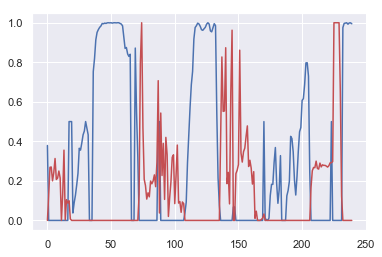

<Figure size 432x288 with 0 Axes>

In [7]:
plt.plot(throttles, 'b-', label='Throttle')
plt.plot(brakes, 'r-', label='Brake')
plt.show()
plt.clf()

### Trace vehicle position

Where the vehicle was located over time is tracked in the `positions` list. This contains a list of (x, y, z) coordinate triplets that the vehicle was observed at. These values represent the vehicle's position on the map in the simulator. To plot them, we simply take the x and y values and plot a dot for every position.

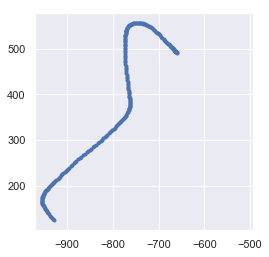

<Figure size 432x288 with 0 Axes>

In [8]:
x = [p[0] for p in positions]
y = [p[1] for p in positions]
plt.plot(x, y, '.')
plt.axis('square')
plt.show()
plt.clf()

### Speed and direction

Combining the wheel speed values with recorded direction vectors can be used to plot in which directions the vehicle was going at what speeds. To this end, we take  the wheel speeds from the `wheelspeeds` list and calculate the angles of the corresponding direction vectors. The resulting data is then displayed as a scatter plot.

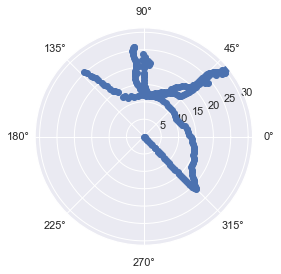

In [9]:
angles = [np.arctan2(d[1], d[0]) for d in directions]
r = wheel_speeds  # We simply use the speed as the radius in the radial plot
plt.subplot(111, projection='polar')
plt.scatter(angles, r)
plt.show()